<a href="https://colab.research.google.com/github/tsultan732/AI_Projects/blob/main/Machine-Learning/Classification_Project/diabetes_classification_and_risk_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, precision_score,
    recall_score, f1_score, roc_auc_score
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

In [3]:
file_path = '/content/drive/MyDrive/Machine Learning/Classification/Pima_Indians_Diabetes_Dataset.csv'

In [4]:
df = pd.read_csv(file_path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


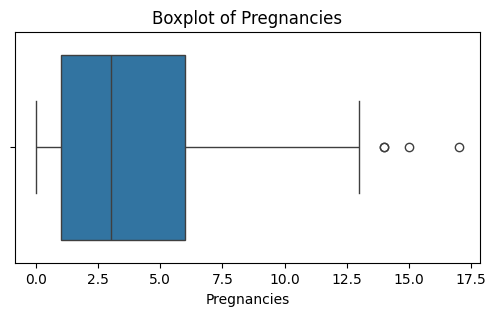

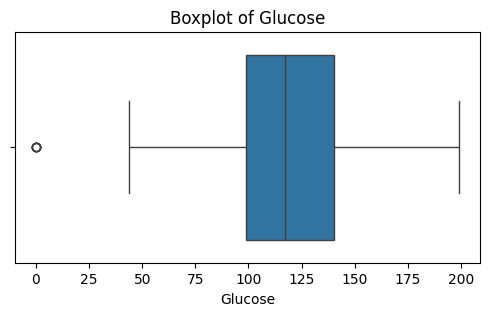

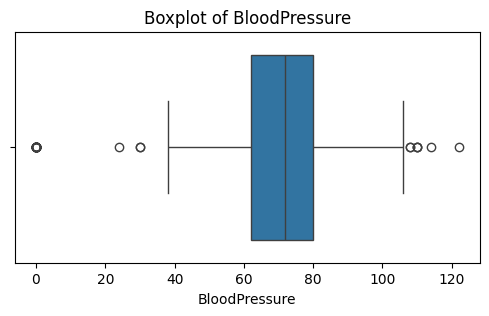

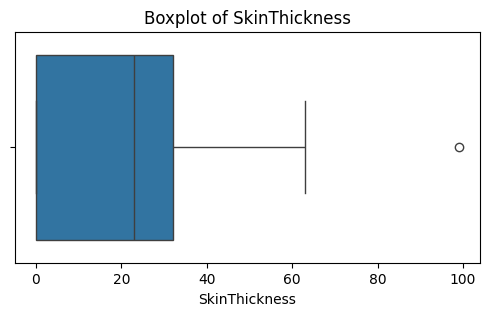

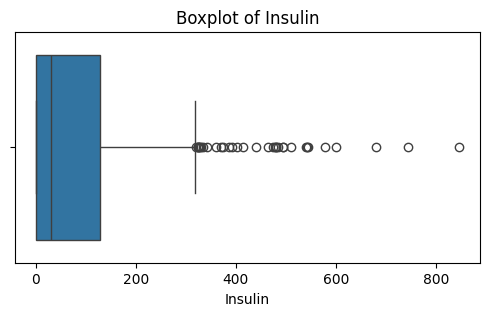

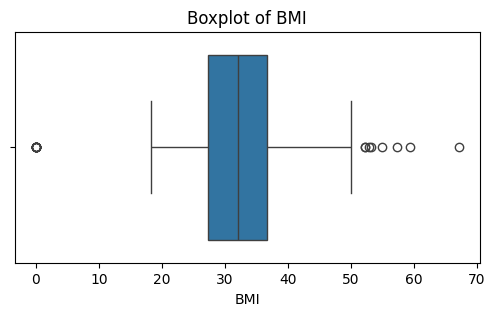

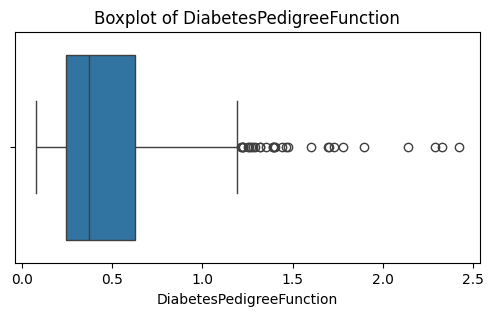

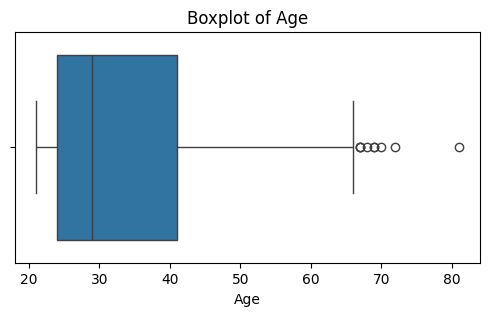

In [8]:
for col in df.columns[:-1]:  # Exclude target
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

Outliers Check

In [9]:
for col in df.columns[:-1]:

  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
  print(f'Outliers in {col}:\n', outliers[col])

Outliers in Pregnancies:
 88     15
159    17
298    14
455    14
Name: Pregnancies, dtype: int64
Outliers in Glucose:
 75     0
182    0
342    0
349    0
502    0
Name: Glucose, dtype: int64
Outliers in BloodPressure:
 7        0
15       0
18      30
43     110
49       0
60       0
78       0
81       0
84     108
106    122
125     30
172      0
177    110
193      0
222      0
261      0
266      0
269      0
300      0
332      0
336      0
347      0
357      0
362    108
426      0
430      0
435      0
453      0
468      0
484      0
494      0
522      0
533      0
535      0
549    110
589      0
597     24
601      0
604      0
619      0
643      0
691    114
697      0
703      0
706      0
Name: BloodPressure, dtype: int64
Outliers in SkinThickness:
 579    99
Name: SkinThickness, dtype: int64
Outliers in Insulin:
 8      543
13     846
54     342
111    495
139    325
153    485
186    495
220    478
228    744
231    370
247    680
248    402
258    375
286    545
29

In [10]:
# Fixing possible erroneous values by replacing zeros and placeholders with NaN,
# then imputing missing and outlier values using median imputation.
df_processed = df.copy()

# Replace invalid zeros/placeholders with NaN
df_processed['Glucose'] = df_processed['Glucose'].replace(0, np.nan)
df_processed['BloodPressure'] = df_processed['BloodPressure'].replace(0, np.nan)
df_processed['SkinThickness'] = df_processed['SkinThickness'].replace(99, np.nan)
df_processed['Insulin'] = df_processed['Insulin'].replace(0, np.nan)
df_processed['BMI'] = df_processed['BMI'].replace(0, np.nan)

# Impute missing values with median
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    median_value = df_processed[col].median()
    df_processed[col].fillna(median_value, inplace=True)

# Optional: cap extremely low Blood Pressure values (e.g., below 40 mmHg)
df_processed['BloodPressure'] = df_processed['BloodPressure'].apply(lambda x: 40 if x < 40 else x)

print(df_processed.isnull().sum())  # Should show 0 NaNs now

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [11]:
# after imputation and capping, confirming data quality before modeling.

for col in df_processed.columns[:-1]:

  Q1 = df_processed[col].quantile(0.25)
  Q3 = df_processed[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  outliers = df_processed[(df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)]
  print(f'Outliers in {col}:\n', outliers[col])

Outliers in Pregnancies:
 88     15
159    17
298    14
455    14
Name: Pregnancies, dtype: int64
Outliers in Glucose:
 Series([], Name: Glucose, dtype: float64)
Outliers in BloodPressure:
 43     110.0
84     108.0
106    122.0
177    110.0
362    108.0
549    110.0
658    106.0
662    106.0
672    106.0
691    114.0
Name: BloodPressure, dtype: float64
Outliers in SkinThickness:
 Series([], Name: SkinThickness, dtype: float64)
Outliers in Insulin:
 3       94.0
4      168.0
6       88.0
8      543.0
13     846.0
       ...  
753    510.0
755    110.0
760     16.0
763    180.0
765    112.0
Name: Insulin, Length: 346, dtype: float64
Outliers in BMI:
 120    53.2
125    55.0
177    67.1
193    52.3
247    52.3
303    52.9
445    59.4
673    57.3
Name: BMI, dtype: float64
Outliers in DiabetesPedigreeFunction:
 4      2.288
12     1.441
39     1.390
45     1.893
58     1.781
100    1.222
147    1.400
187    1.321
218    1.224
228    2.329
243    1.318
245    1.213
259    1.353
292    1.224

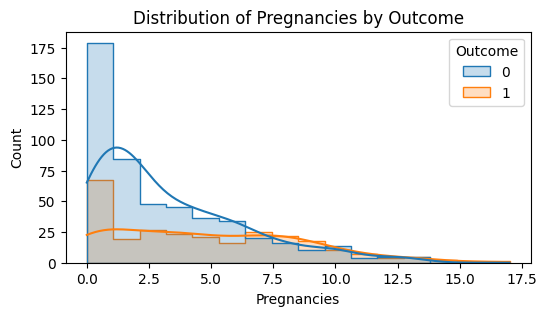

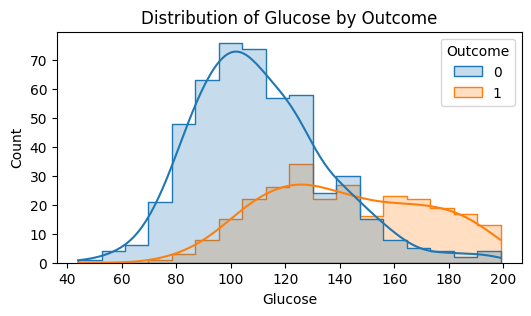

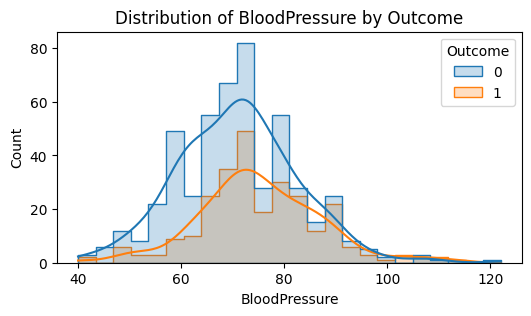

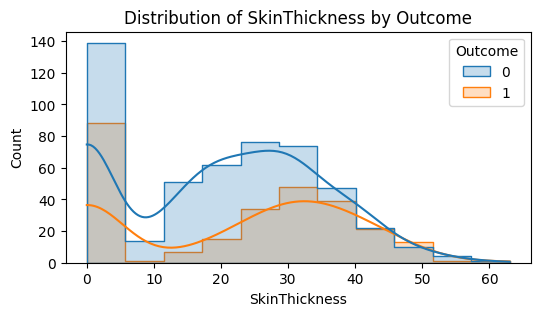

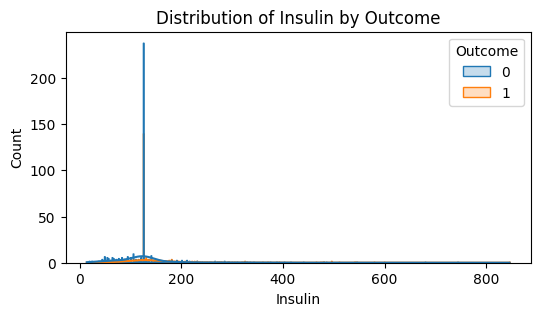

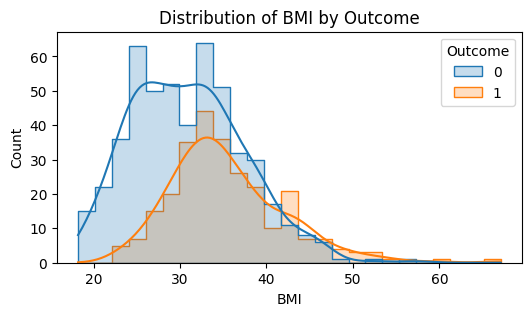

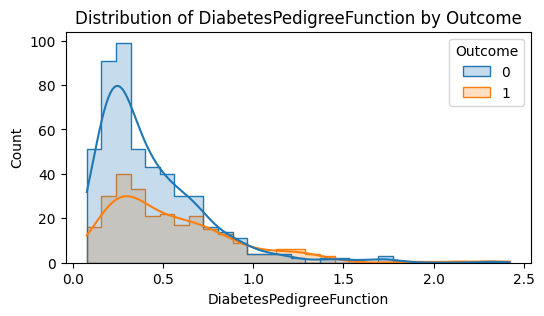

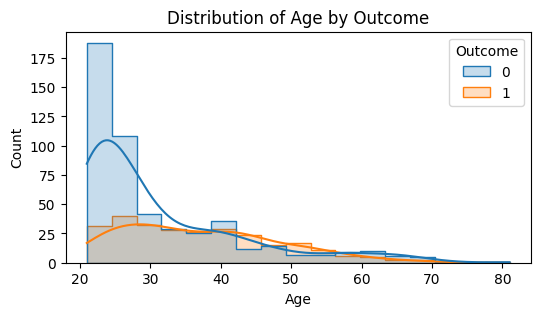

In [12]:
for col in df_processed.columns[:-1]:  # Exclude target
    plt.figure(figsize=(6,3))
    sns.histplot(data=df_processed, x=col, hue='Outcome', kde=True, element='step')
    plt.title(f'Distribution of {col} by Outcome')
    plt.show()

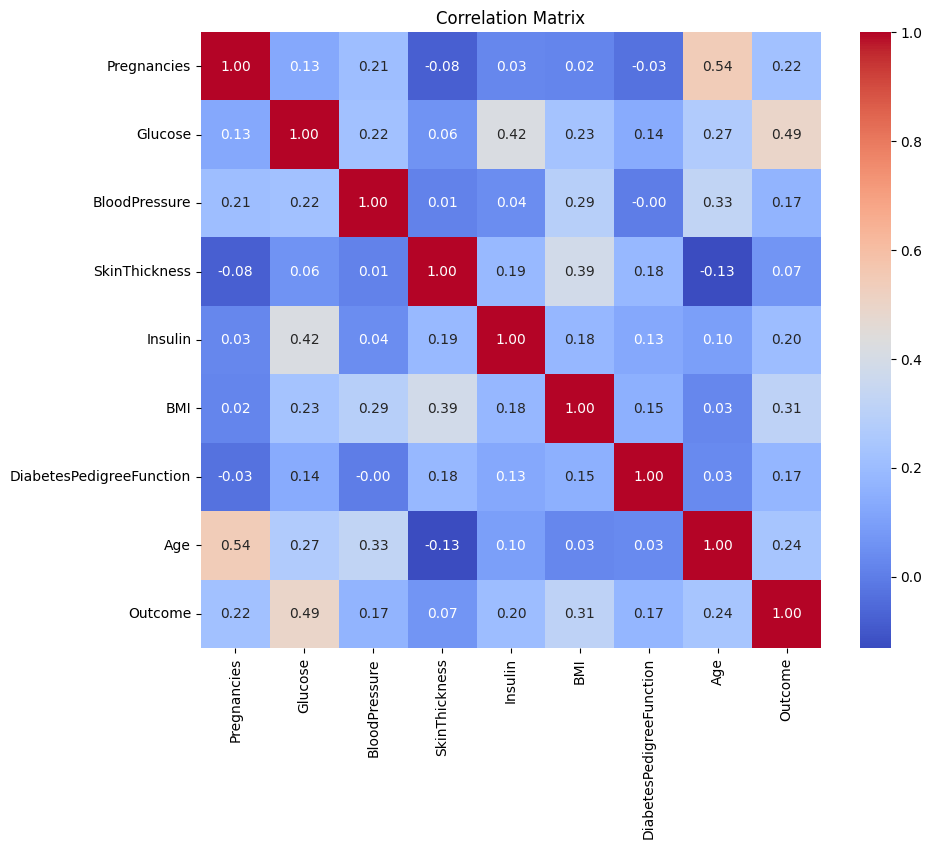

In [13]:
corr = df_processed.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Preparing Data

In [14]:
# Prepare your data
X = df_processed.drop('Outcome', axis=1)  # assuming 'Outcome' is your target
y = df_processed['Outcome']

predictors = X.columns.tolist()
predictors

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

# Statistical Analysis & Logistic Regression

In [15]:
# Split the data

def split_data(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
  return X_train, X_test, y_train, y_test

In [16]:
def Scaling(X):

  scalers = ['No Scaling', 'Standard Scaling', 'Robust Scaling']

  scaled_sets = {}

  for scaler_name in scalers:
    if scaler_name == 'Standard Scaling':
      scaler = StandardScaler()
    elif scaler_name == 'Robust Scaling':
      scaler = RobustScaler()
    else:
      scaler = None

    if scaler:
      scaled_sets[scaler_name] = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
    else:
      scaled_sets[scaler_name] = X.copy()

  return scaled_sets

In [17]:
def logit_test(X, y, alpha=0.05, decimals=4):
    X_sm = sm.add_constant(X)
    logit_model = sm.Logit(y, X_sm)   # <-- fixed: should use X_sm not X
    logit_result = logit_model.fit(disp=0)

    # Round p-values to decimals
    pvalues = logit_result.pvalues.round(decimals)

    # Insignificant predictors
    insignificant_predictors = pvalues[pvalues > alpha].index.tolist()
    if 'const' in insignificant_predictors:
        insignificant_predictors.remove('const')

    # VIF calculation
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_sm.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X_sm.values, i)
        for i in range(X_sm.shape[1])
    ]
    vif_data["VIF"] = vif_data["VIF"].round(decimals)

    return {
        'model': logit_result,
        'pvalues': pvalues.to_dict(),   # dict instead of Series
        'log_likelihood': round(logit_result.llf, decimals),
        'log_likelihood_null': round(logit_result.llnull, decimals),
        'llr_pvalue': round(logit_result.llr_pvalue, decimals),
        'pseudo_r2': round(logit_result.prsquared, decimals),
        'aic': round(logit_result.aic, decimals),
        'bic': round(logit_result.bic, decimals),
        'insignificant_predictors': insignificant_predictors,
        'vif': vif_data
    }

In [18]:
def tune_logistic_regression(X, y, cv=5, scoring='accuracy', n_jobs=-1):

    # Logistic Regression model
    log_reg = LogisticRegression(max_iter=10000)

    # Define hyperparameter grid
    param_grid = [
    # Liblinear solver → supports l1 and l2 (binary only)
    {
        "solver": ["liblinear"],
        "penalty": ["l1", "l2"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "class_weight": [None, "balanced"],
        "fit_intercept": [True, False],
        "max_iter": [100, 200, 500],
        "tol": [1e-4, 1e-3]
    },

    # Saga solver → supports l1, l2, elasticnet (binary + multinomial)
    {
        "solver": ["saga"],
        "penalty": ["l1", "l2", "elasticnet"],
        "l1_ratio": [0, 0.5, 1],   # only used if penalty='elasticnet'
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "class_weight": [None, "balanced"],
        "fit_intercept": [True, False],
        "multi_class": ["ovr", "multinomial"],
        "max_iter": [100, 200, 500],
        "tol": [1e-4, 1e-3]
    },

    # LBFGS solver → supports only l2 or no penalty (binary + multinomial)
    {
        "solver": ["lbfgs"],
        "penalty": ["l2", None],
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "class_weight": [None, "balanced"],
        "fit_intercept": [True, False],
        "multi_class": ["ovr", "multinomial"],
        "max_iter": [100, 200, 500],
        "tol": [1e-4, 1e-3]
    },

    # Newton-CG solver → supports only l2 or no penalty (binary + multinomial)
    {
        "solver": ["newton-cg"],
        "penalty": ["l2", None],
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "class_weight": [None, "balanced"],
        "fit_intercept": [True, False],
        "multi_class": ["ovr", "multinomial"],
        "max_iter": [100, 200, 500],
        "tol": [1e-4, 1e-3]
    },

    # SAG solver → supports only l2 or no penalty (large datasets, stochastic)
    {
        "solver": ["sag"],
        "penalty": ["l2", None],
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "class_weight": [None, "balanced"],
        "fit_intercept": [True, False],
        "multi_class": ["ovr", "multinomial"],
        "max_iter": [100, 200, 500],
        "tol": [1e-4, 1e-3]
    }
    ]

    # GridSearch
    grid_search = GridSearchCV(
        estimator=log_reg,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        verbose=1
    )

    # Fit
    grid_search.fit(X, y)

    return grid_search

In [19]:
def Logistic_Regression(X_train, X_test, y_train, y_test):
    # Perform hyperparameter tuning
    grid_search = tune_logistic_regression(X_train, y_train, cv=5)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Predictions - Training
    y_train_pred = best_model.predict(X_train)
    y_train_proba = best_model.predict_proba(X_train)[:, 1]

    # Predictions - Testing
    y_test_pred = best_model.predict(X_test)
    y_test_proba = best_model.predict_proba(X_test)[:, 1]

    # Training metrics
    train_metrics = {
        "accuracy": accuracy_score(y_train, y_train_pred),
        "precision": precision_score(y_train, y_train_pred),
        "recall": recall_score(y_train, y_train_pred),
        "f1": f1_score(y_train, y_train_pred),
        "roc_auc": roc_auc_score(y_train, y_train_proba),
        "confusion_matrix": confusion_matrix(y_train, y_train_pred)
    }

    # Testing metrics
    test_metrics = {
        "accuracy": accuracy_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred),
        "recall": recall_score(y_test, y_test_pred),
        "f1": f1_score(y_test, y_test_pred),
        "roc_auc": roc_auc_score(y_test, y_test_proba),
        "confusion_matrix": confusion_matrix(y_test, y_test_pred)
    }

    return {
        "best_model": best_model,
        "best_params": grid_search.best_params_,
        "cv_score": grid_search.best_score_,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics
    }

In [20]:
def add_in_results(scaled_data):
    results = {}

    for scaler_name, X_scaled in scaled_data.items():
        if scaler_name != 'No Scaling':
          results[scaler_name] = logit_test(X_scaled, y)

          X_train, X_test, y_train, y_test = split_data(X_scaled, y)
          log_reg_results = Logistic_Regression(X_train, X_test, y_train, y_test)

          # Add details
          results[scaler_name]['logistic_regression'] = log_reg_results
          results[scaler_name]['dataset'] = X_scaled

    return results

In [21]:
def print_results(results):
    for scaler_name, res in results.items():
        print(f"\n{'='*50}")
        print(f"Testing: {scaler_name}")
        print(f"{'='*50}")

        # Original statsmodels logit results
        print(f"Log-Likelihood        : {res['log_likelihood']:.4f}")
        print(f"Null Log-Likelihood   : {res['log_likelihood_null']:.4f}")
        print(f"LLR p-value           : {res['llr_pvalue']:.4e}")
        print(f"Pseudo R²             : {res['pseudo_r2']:.4f}")
        print(f"AIC                   : {res['aic']:.4f}")
        print(f"BIC                   : {res['bic']:.4f}")

        if "accuracy" in res:  # legacy key
            print(f"Accuracy (Test set)   : {res['accuracy']:.4f}")

        print(f"Insignificant Predictors: {res['insignificant_predictors']}")

        print("\nP-values:")
        for k, v in res['pvalues'].items():
            print(f"  {k:25s}: {v:.4f}")

        # Print VIF table
        if "vif" in res:
            print("\nVIF (Variance Inflation Factor):")
            print(res['vif'].to_string(index=False))

        # Logistic Regression tuned results
        if "logistic_regression" in res:
            log_reg_res = res["logistic_regression"]

            if isinstance(log_reg_res, dict):
                print("\nLogistic Regression (with hyperparameter tuning):")
                print(f"  Best Params        : {log_reg_res['best_params']}")
                print(f"  CV Score (mean)    : {log_reg_res['cv_score']:.4f}")

                # Training Metrics
                print("\nTraining Performance:")
                print(f"  Accuracy           : {log_reg_res['train_metrics']['accuracy']:.4f}")
                print(f"  Precision          : {log_reg_res['train_metrics']['precision']:.4f}")
                print(f"  Recall             : {log_reg_res['train_metrics']['recall']:.4f}")
                print(f"  F1-Score           : {log_reg_res['train_metrics']['f1']:.4f}")
                print(f"  ROC AUC            : {log_reg_res['train_metrics']['roc_auc']:.4f}")
                print("  Confusion Matrix:")
                print(log_reg_res["train_metrics"]["confusion_matrix"])

                # Testing Metrics
                print("\nTesting Performance:")
                print(f"  Accuracy           : {log_reg_res['test_metrics']['accuracy']:.4f}")
                print(f"  Precision          : {log_reg_res['test_metrics']['precision']:.4f}")
                print(f"  Recall             : {log_reg_res['test_metrics']['recall']:.4f}")
                print(f"  F1-Score           : {log_reg_res['test_metrics']['f1']:.4f}")
                print(f"  ROC AUC            : {log_reg_res['test_metrics']['roc_auc']:.4f}")
                print("  Confusion Matrix:")
                print(log_reg_res["test_metrics"]["confusion_matrix"])

In [22]:
scaled_data = Scaling(X)
scaled_data

{'No Scaling':      Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
 0              6    148.0           72.0           35.0    125.0  33.6   
 1              1     85.0           66.0           29.0    125.0  26.6   
 2              8    183.0           64.0            0.0    125.0  23.3   
 3              1     89.0           66.0           23.0     94.0  28.1   
 4              0    137.0           40.0           35.0    168.0  43.1   
 ..           ...      ...            ...            ...      ...   ...   
 763           10    101.0           76.0           48.0    180.0  32.9   
 764            2    122.0           70.0           27.0    125.0  36.8   
 765            5    121.0           72.0           23.0    112.0  26.2   
 766            1    126.0           60.0            0.0    125.0  30.1   
 767            1     93.0           70.0           31.0    125.0  30.4   
 
      DiabetesPedigreeFunction  Age  
 0                       0.627   50  
 1      

In [23]:
results_1 = add_in_results(scaled_data)

Fitting 5 folds for each of 4608 candidates, totalling 23040 fits
Fitting 5 folds for each of 4608 candidates, totalling 23040 fits


In [24]:
print_results(results_1)


Testing: Standard Scaling
Log-Likelihood        : -355.8592
Null Log-Likelihood   : -496.7420
LLR p-value           : 0.0000e+00
Pseudo R²             : 0.2836
AIC                   : 729.7183
BIC                   : 771.5124
Insignificant Predictors: ['BloodPressure', 'SkinThickness', 'Insulin', 'Age']

P-values:
  const                    : 0.0000
  Pregnancies              : 0.0001
  Glucose                  : 0.0000
  BloodPressure            : 0.2630
  SkinThickness            : 0.2745
  Insulin                  : 0.4045
  BMI                      : 0.0000
  DiabetesPedigreeFunction : 0.0022
  Age                      : 0.2009

VIF (Variance Inflation Factor):
                 Feature    VIF
                   const 1.0000
             Pregnancies 1.4299
                 Glucose 1.3642
           BloodPressure 1.2536
           SkinThickness 1.2581
                 Insulin 1.2641
                     BMI 1.3525
DiabetesPedigreeFunction 1.0672
                     Age 1.6278

Logi

## Testing different predictors

In [25]:
predictors_2 = [col for col in predictors if col not in results_1['Standard Scaling']['insignificant_predictors']]
predictors_2

['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction']

In [26]:
X_2 = df_processed[predictors_2]
X_2

,Pregnancies,Glucose,BMI,DiabetesPedigreeFunction
0,6,148.0,33.6,0.627
1,1,85.0,26.6,0.351
2,8,183.0,23.3,0.672
3,1,89.0,28.1,0.167
4,0,137.0,43.1,2.288
...,...,...,...,...
763,10,101.0,32.9,0.171
764,2,122.0,36.8,0.340
765,5,121.0,26.2,0.245
766,1,126.0,30.1,0.349


In [27]:
scaled_data_2 = Scaling(X_2)

In [28]:
results_2 = add_in_results(scaled_data_2)

Fitting 5 folds for each of 4608 candidates, totalling 23040 fits
Fitting 5 folds for each of 4608 candidates, totalling 23040 fits


In [29]:
print_results(results_2)


Testing: Standard Scaling
Log-Likelihood        : -358.1828
Null Log-Likelihood   : -496.7420
LLR p-value           : 0.0000e+00
Pseudo R²             : 0.2789
AIC                   : 726.3656
BIC                   : 749.5845
Insignificant Predictors: []

P-values:
  const                    : 0.0000
  Pregnancies              : 0.0000
  Glucose                  : 0.0000
  BMI                      : 0.0000
  DiabetesPedigreeFunction : 0.0028

VIF (Variance Inflation Factor):
                 Feature    VIF
                   const 1.0000
             Pregnancies 1.0195
                 Glucose 1.0872
                     BMI 1.0735
DiabetesPedigreeFunction 1.0385

Logistic Regression (with hyperparameter tuning):
  Best Params        : {'C': 0.001, 'class_weight': None, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
  CV Score (mean)    : 0.7900

Training Performance:
  Accuracy           : 0.7948
  Precision          : 0.7444
  Recall  

# Adding Interaction Terms

In [30]:
predictors_3 = [col for col in predictors_2 if col not in results_2['Standard Scaling']['insignificant_predictors']]
predictors_3

['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction']

In [31]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_inter = poly.fit_transform(df_processed[predictors_3])

# Get feature names
feature_names = poly.get_feature_names_out(predictors_3)

X_3 = pd.DataFrame(X_inter, columns=feature_names)
X_3.head()

,Pregnancies,Glucose,BMI,DiabetesPedigreeFunction,Pregnancies Glucose,Pregnancies BMI,Pregnancies DiabetesPedigreeFunction,Glucose BMI,Glucose DiabetesPedigreeFunction,BMI DiabetesPedigreeFunction
0,6.0,148.0,33.6,0.627,888.0,201.6,3.762,4972.8,92.796,21.0672
1,1.0,85.0,26.6,0.351,85.0,26.6,0.351,2261.0,29.835,9.3366
2,8.0,183.0,23.3,0.672,1464.0,186.4,5.376,4263.9,122.976,15.6576
3,1.0,89.0,28.1,0.167,89.0,28.1,0.167,2500.9,14.863,4.6927
4,0.0,137.0,43.1,2.288,0.0,0.0,0.000,5904.7,313.456,98.6128


In [32]:
scaled_data_3 = Scaling(X_3)

In [33]:
results_3 = add_in_results(scaled_data_3)

Fitting 5 folds for each of 4608 candidates, totalling 23040 fits
Fitting 5 folds for each of 4608 candidates, totalling 23040 fits


In [34]:
print_results(results_3)


Testing: Standard Scaling
Log-Likelihood        : -351.8954
Null Log-Likelihood   : -496.7420
LLR p-value           : 0.0000e+00
Pseudo R²             : 0.2916
AIC                   : 725.7907
BIC                   : 776.8724
Insignificant Predictors: ['Pregnancies', 'BMI', 'Pregnancies Glucose', 'Pregnancies BMI', 'Pregnancies DiabetesPedigreeFunction', 'Glucose BMI', 'BMI DiabetesPedigreeFunction']

P-values:
  const                    : 0.0000
  Pregnancies              : 0.0714
  Glucose                  : 0.0008
  BMI                      : 0.0701
  DiabetesPedigreeFunction : 0.0066
  Pregnancies Glucose      : 0.0624
  Pregnancies BMI          : 0.9846
  Pregnancies DiabetesPedigreeFunction: 0.3601
  Glucose BMI              : 0.5553
  Glucose DiabetesPedigreeFunction: 0.0038
  BMI DiabetesPedigreeFunction: 0.8008

VIF (Variance Inflation Factor):
                             Feature     VIF
                               const  1.0000
                         Pregnancies 36.031

In [35]:
predictors_4 = [col for col in predictors_3 if col not in results_3['Standard Scaling']['insignificant_predictors']]
predictors_4

['Glucose', 'DiabetesPedigreeFunction']

In [36]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_inter = poly.fit_transform(df_processed[predictors_4])

# Get feature names
feature_names = poly.get_feature_names_out(predictors_4)

X_4 = pd.DataFrame(X_inter, columns=feature_names)
X_4.head()

,Glucose,DiabetesPedigreeFunction,Glucose DiabetesPedigreeFunction
0,148.0,0.627,92.796
1,85.0,0.351,29.835
2,183.0,0.672,122.976
3,89.0,0.167,14.863
4,137.0,2.288,313.456


In [37]:
scaled_data_4 = Scaling(X_4)

In [38]:
results_4 = add_in_results(scaled_data_4)

Fitting 5 folds for each of 4608 candidates, totalling 23040 fits
Fitting 5 folds for each of 4608 candidates, totalling 23040 fits


In [39]:
print_results(results_4)


Testing: Standard Scaling
Log-Likelihood        : -388.0587
Null Log-Likelihood   : -496.7420
LLR p-value           : 0.0000e+00
Pseudo R²             : 0.2188
AIC                   : 784.1174
BIC                   : 802.6926
Insignificant Predictors: []

P-values:
  const                    : 0.0000
  Glucose                  : 0.0000
  DiabetesPedigreeFunction : 0.0010
  Glucose DiabetesPedigreeFunction: 0.0094

VIF (Variance Inflation Factor):
                         Feature     VIF
                           const  1.0000
                         Glucose  2.8037
        DiabetesPedigreeFunction 15.5924
Glucose DiabetesPedigreeFunction 18.7583

Logistic Regression (with hyperparameter tuning):
  Best Params        : {'C': 0.1, 'class_weight': None, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 100, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'tol': 0.001}
  CV Score (mean)    : 0.7623

Training Performance:
  Accuracy           : 0.7606
  Precisi

# Adding Poly Degree 2

In [40]:
X_5 = X_4.copy()
X_5.head()

,Glucose,DiabetesPedigreeFunction,Glucose DiabetesPedigreeFunction
0,148.0,0.627,92.796
1,85.0,0.351,29.835
2,183.0,0.672,122.976
3,89.0,0.167,14.863
4,137.0,2.288,313.456


In [41]:
for col in predictors_4:
  if col in predictors:
    X_5[col+'^2'] = X_5[col] ** 2

X_5

,Glucose,DiabetesPedigreeFunction,Glucose DiabetesPedigreeFunction,Glucose^2,DiabetesPedigreeFunction^2
0,148.0,0.627,92.796,21904.0,0.393129
1,85.0,0.351,29.835,7225.0,0.123201
2,183.0,0.672,122.976,33489.0,0.451584
3,89.0,0.167,14.863,7921.0,0.027889
4,137.0,2.288,313.456,18769.0,5.234944
...,...,...,...,...,...
763,101.0,0.171,17.271,10201.0,0.029241
764,122.0,0.340,41.480,14884.0,0.115600
765,121.0,0.245,29.645,14641.0,0.060025
766,126.0,0.349,43.974,15876.0,0.121801


In [42]:
predictors_5 = X_5.columns.tolist()
predictors_5

['Glucose',
 'DiabetesPedigreeFunction',
 'Glucose DiabetesPedigreeFunction',
 'Glucose^2',
 'DiabetesPedigreeFunction^2']

In [43]:
scaled_data_5 = Scaling(X_5)

In [44]:
results_5 = add_in_results(scaled_data_5)

Fitting 5 folds for each of 4608 candidates, totalling 23040 fits
Fitting 5 folds for each of 4608 candidates, totalling 23040 fits


In [45]:
print_results(results_5)


Testing: Standard Scaling
Log-Likelihood        : -385.9023
Null Log-Likelihood   : -496.7420
LLR p-value           : 0.0000e+00
Pseudo R²             : 0.2231
AIC                   : 783.8046
BIC                   : 811.6674
Insignificant Predictors: ['Glucose DiabetesPedigreeFunction', 'Glucose^2', 'DiabetesPedigreeFunction^2']

P-values:
  const                    : 0.0000
  Glucose                  : 0.0039
  DiabetesPedigreeFunction : 0.0004
  Glucose DiabetesPedigreeFunction: 0.0916
  Glucose^2                : 0.2344
  DiabetesPedigreeFunction^2: 0.0961

VIF (Variance Inflation Factor):
                         Feature     VIF
                           const  1.0000
                         Glucose 51.4911
        DiabetesPedigreeFunction 16.5605
Glucose DiabetesPedigreeFunction 24.1374
                       Glucose^2 53.0373
      DiabetesPedigreeFunction^2  8.6086

Logistic Regression (with hyperparameter tuning):
  Best Params        : {'C': 0.1, 'class_weight': None, 'fit

## Adding Interaction Terms and Polynomial Terms on Predictors 3

In [46]:
# Select only the predictors from your dataframe
X_base = df_processed[predictors_3]

# Generate polynomial + interaction terms (degree=2 includes square + interactions)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_6 = poly.fit_transform(X_base)

# Convert back to DataFrame with proper column names
X_6 = pd.DataFrame(X_6, columns=poly.get_feature_names_out(predictors_3))

X_6.head()

,Pregnancies,Glucose,BMI,DiabetesPedigreeFunction,Pregnancies^2,Pregnancies Glucose,Pregnancies BMI,Pregnancies DiabetesPedigreeFunction,Glucose^2,Glucose BMI,Glucose DiabetesPedigreeFunction,BMI^2,BMI DiabetesPedigreeFunction,DiabetesPedigreeFunction^2
0,6.0,148.0,33.6,0.627,36.0,888.0,201.6,3.762,21904.0,4972.8,92.796,1128.96,21.0672,0.393129
1,1.0,85.0,26.6,0.351,1.0,85.0,26.6,0.351,7225.0,2261.0,29.835,707.56,9.3366,0.123201
2,8.0,183.0,23.3,0.672,64.0,1464.0,186.4,5.376,33489.0,4263.9,122.976,542.89,15.6576,0.451584
3,1.0,89.0,28.1,0.167,1.0,89.0,28.1,0.167,7921.0,2500.9,14.863,789.61,4.6927,0.027889
4,0.0,137.0,43.1,2.288,0.0,0.0,0.0,0.000,18769.0,5904.7,313.456,1857.61,98.6128,5.234944


In [47]:
predictors_6 = X_6.columns.tolist()
predictors_6

['Pregnancies',
 'Glucose',
 'BMI',
 'DiabetesPedigreeFunction',
 'Pregnancies^2',
 'Pregnancies Glucose',
 'Pregnancies BMI',
 'Pregnancies DiabetesPedigreeFunction',
 'Glucose^2',
 'Glucose BMI',
 'Glucose DiabetesPedigreeFunction',
 'BMI^2',
 'BMI DiabetesPedigreeFunction',
 'DiabetesPedigreeFunction^2']

In [48]:
scaled_data_6 = Scaling(X_6)

In [49]:
results_6 = add_in_results(scaled_data_6)

Fitting 5 folds for each of 4608 candidates, totalling 23040 fits
Fitting 5 folds for each of 4608 candidates, totalling 23040 fits


In [50]:
print_results(results_6)


Testing: Standard Scaling
Log-Likelihood        : -348.4310
Null Log-Likelihood   : -496.7420
LLR p-value           : 0.0000e+00
Pseudo R²             : 0.2986
AIC                   : 726.8620
BIC                   : 796.5188
Insignificant Predictors: ['Pregnancies^2', 'Pregnancies Glucose', 'Pregnancies BMI', 'Pregnancies DiabetesPedigreeFunction', 'Glucose^2', 'Glucose BMI', 'BMI DiabetesPedigreeFunction', 'DiabetesPedigreeFunction^2']

P-values:
  const                    : 0.0000
  Pregnancies              : 0.0460
  Glucose                  : 0.0071
  BMI                      : 0.0067
  DiabetesPedigreeFunction : 0.0118
  Pregnancies^2            : 0.9585
  Pregnancies Glucose      : 0.0633
  Pregnancies BMI          : 0.5291
  Pregnancies DiabetesPedigreeFunction: 0.4526
  Glucose^2                : 0.2474
  Glucose BMI              : 0.6411
  Glucose DiabetesPedigreeFunction: 0.0166
  BMI^2                    : 0.0337
  BMI DiabetesPedigreeFunction: 0.8051
  DiabetesPedigreeFun

In [51]:
predictors_7 = [col for col in predictors_6 if col not in results_6['Standard Scaling']['insignificant_predictors']]
predictors_7

['Pregnancies',
 'Glucose',
 'BMI',
 'DiabetesPedigreeFunction',
 'Glucose DiabetesPedigreeFunction',
 'BMI^2']

In [52]:
X_7 = X_6[predictors_7]
X_7

,Pregnancies,Glucose,BMI,DiabetesPedigreeFunction,Glucose DiabetesPedigreeFunction,BMI^2
0,6.0,148.0,33.6,0.627,92.796,1128.96
1,1.0,85.0,26.6,0.351,29.835,707.56
2,8.0,183.0,23.3,0.672,122.976,542.89
3,1.0,89.0,28.1,0.167,14.863,789.61
4,0.0,137.0,43.1,2.288,313.456,1857.61
...,...,...,...,...,...,...
763,10.0,101.0,32.9,0.171,17.271,1082.41
764,2.0,122.0,36.8,0.340,41.480,1354.24
765,5.0,121.0,26.2,0.245,29.645,686.44
766,1.0,126.0,30.1,0.349,43.974,906.01


In [53]:
scaled_data_7 = Scaling(X_7)

In [54]:
results_7 = add_in_results(scaled_data_7)

Fitting 5 folds for each of 4608 candidates, totalling 23040 fits
Fitting 5 folds for each of 4608 candidates, totalling 23040 fits


In [55]:
print_results(results_7)


Testing: Standard Scaling
Log-Likelihood        : -351.8446
Null Log-Likelihood   : -496.7420
LLR p-value           : 0.0000e+00
Pseudo R²             : 0.2917
AIC                   : 717.6892
BIC                   : 750.1957
Insignificant Predictors: []

P-values:
  const                    : 0.0000
  Pregnancies              : 0.0000
  Glucose                  : 0.0000
  BMI                      : 0.0022
  DiabetesPedigreeFunction : 0.0002
  Glucose DiabetesPedigreeFunction: 0.0017
  BMI^2                    : 0.0331

VIF (Variance Inflation Factor):
                         Feature     VIF
                           const  1.0000
                     Pregnancies  1.0365
                         Glucose  2.8719
                             BMI 41.7822
        DiabetesPedigreeFunction 15.6622
Glucose DiabetesPedigreeFunction 18.9073
                           BMI^2 41.6599

Logistic Regression (with hyperparameter tuning):
  Best Params        : {'C': 0.01, 'class_weight': None, 'fit

In [56]:
# List of datasets having No Insignificant features
dataset_0_insig = {}
dataset_0_insig['X_2'] = X_2
dataset_0_insig['X_4'] = X_4
dataset_0_insig['X_7'] = X_7

# Classifications using `LDA`, `QDA`, `Naive Bayes`, `KNN`, `SVM`, `Decision Tree`, `Random Forest`  

In [57]:
def evaluate_model(grid_search, X_train, y_train, X_test, y_test):
    best_model = grid_search.best_estimator_

    # Predictions - Training
    y_train_pred = best_model.predict(X_train)
    y_train_proba = best_model.predict_proba(X_train)[:, 1]

    # Predictions - Testing
    y_test_pred = best_model.predict(X_test)
    y_test_proba = best_model.predict_proba(X_test)[:, 1]

    # Training metrics
    train_metrics = {
        "accuracy": accuracy_score(y_train, y_train_pred),
        "precision": precision_score(y_train, y_train_pred),
        "recall": recall_score(y_train, y_train_pred),
        "f1": f1_score(y_train, y_train_pred),
        "roc_auc": roc_auc_score(y_train, y_train_proba),
        "confusion_matrix": confusion_matrix(y_train, y_train_pred)
    }

    # Testing metrics
    test_metrics = {
        "accuracy": accuracy_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred),
        "recall": recall_score(y_test, y_test_pred),
        "f1": f1_score(y_test, y_test_pred),
        "roc_auc": roc_auc_score(y_test, y_test_proba),
        "confusion_matrix": confusion_matrix(y_test, y_test_pred),
        "classification_report": classification_report(y_test, y_test_pred, output_dict=True)
    }

    return {
        "best_model": best_model,
        "best_params": grid_search.best_params_,
        "cv_score": grid_search.best_score_,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics
    }

In [58]:
# Common print function for models (LDA, QDA, KNN, NB, SVM, DT, RF)
def print_model_results(model_name, results):
    print(f"{model_name} Results:")
    print(f"  Best Params : {results['best_params']}")
    print(f"  CV Score    : {results['cv_score']:.4f}")
    print(f"  Train Acc   : {results['train_metrics']['accuracy']:.4f}")
    print(f"  Test Acc    : {results['test_metrics']['accuracy']:.4f}")
    print(f"  Test F1     : {results['test_metrics']['f1']:.4f}")
    print(f"  Test ROC    : {results['test_metrics']['roc_auc']:.4f}")
    print("-------------------------------------------------")

### LDA & QDA

In [59]:
def tune_lda(X, y, cv=5):
    lda = LinearDiscriminantAnalysis()
    param_grid = [
        # svd solver → ignores shrinkage
        {
            'solver': ['svd']
        },
        # lsqr/eigen solvers → support shrinkage
        {
            'solver': ['lsqr', 'eigen'],
            'shrinkage': [None, 'auto', 0.0, 0.1, 0.2, 0.5, 0.9]
        }
    ]
    grid = GridSearchCV(lda, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid.fit(X, y)
    return grid

In [60]:
def tune_qda(X, y, cv=5):
    qda = QuadraticDiscriminantAnalysis()
    param_grid = {
        'reg_param': [0.0, 0.01, 0.1, 0.2, 0.5, 0.9]  # Regularization for stability
    }
    grid = GridSearchCV(qda, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid.fit(X, y)
    return grid

In [61]:
da_results = {}

for X_name, data in dataset_0_insig.items():
    da_results[X_name] = {}
    print(f"\n--- Running dataset: {X_name} ---")
    scaled_data = Scaling(data)

    for scaler_name, X_scaled in scaled_data.items():
        if scaler_name != 'No Scaling':
            da_results[X_name][scaler_name] = {}

            print(f"Scaler: {scaler_name} -> starting GridSearchCV")
            print("=================================================")

            # Split data
            X_train, X_test, y_train, y_test = split_data(X_scaled, y)

            # LDA
            lda_grid = tune_lda(X_train, y_train)
            lda_results = evaluate_model(lda_grid, X_train, y_train, X_test, y_test)
            da_results[X_name][scaler_name]["LDA"] = lda_results
            print_model_results("LDA", lda_results)

            # QDA
            qda_grid = tune_qda(X_train, y_train)
            qda_results = evaluate_model(qda_grid, X_train, y_train, X_test, y_test)
            da_results[X_name][scaler_name]["QDA"] = qda_results
            print_model_results("QDA", qda_results)

            print("=================================================\n")


--- Running dataset: X_2 ---
Scaler: Standard Scaling -> starting GridSearchCV
LDA Results:
  Best Params : {'shrinkage': 0.9, 'solver': 'lsqr'}
  CV Score    : 0.7883
  Train Acc   : 0.7915
  Test Acc    : 0.7013
  Test F1     : 0.5306
  Test ROC    : 0.8120
-------------------------------------------------
QDA Results:
  Best Params : {'reg_param': 0.9}
  CV Score    : 0.7883
  Train Acc   : 0.7948
  Test Acc    : 0.7078
  Test F1     : 0.5361
  Test ROC    : 0.8096
-------------------------------------------------

Scaler: Robust Scaling -> starting GridSearchCV
LDA Results:
  Best Params : {'shrinkage': 0.9, 'solver': 'lsqr'}
  CV Score    : 0.7899
  Train Acc   : 0.7899
  Test Acc    : 0.7078
  Test F1     : 0.5361
  Test ROC    : 0.8072
-------------------------------------------------
QDA Results:
  Best Params : {'reg_param': 0.0}
  CV Score    : 0.7851
  Train Acc   : 0.7834
  Test Acc    : 0.7208
  Test F1     : 0.5905
  Test ROC    : 0.7874
---------------------------------

# Naive Bayes

In [62]:
# No hyperparameters to tune for GaussianNB typically, but you can do validation if desired

def tune_naive_bayes(X, y, cv=5):
    nb = GaussianNB()
    # No hyperparameter grid needed generally, so just perform CV scoring
    grid = GridSearchCV(nb, param_grid={}, cv=cv, scoring='accuracy', n_jobs=-1)
    grid.fit(X, y)
    return grid

In [63]:
NB_results = {}

for X_name, data in dataset_0_insig.items():
    NB_results[X_name] = {}
    scaled_data = Scaling(data)

    for scaler_name, X_scaled in scaled_data.items():
        if scaler_name != 'No Scaling':
            NB_results[X_name][scaler_name] = {}

            print(f"For dataset {X_name} and Scaler name {scaler_name}")
            print("=================================================")

            # Split
            X_train, X_test, y_train, y_test = split_data(X_scaled, y)

            # Naive Bayes
            nb_grid = tune_naive_bayes(X_train, y_train)
            nb_results = evaluate_model(nb_grid, X_train, y_train, X_test, y_test)

            # Save results
            NB_results[X_name][scaler_name]["NaiveBayes"] = nb_results

            # Print neatly
            print_model_results("Naive Bayes", nb_results)

            print("=================================================\n")

For dataset X_2 and Scaler name Standard Scaling
Naive Bayes Results:
  Best Params : {}
  CV Score    : 0.7834
  Train Acc   : 0.7932
  Test Acc    : 0.7143
  Test F1     : 0.5769
  Test ROC    : 0.7944
-------------------------------------------------

For dataset X_2 and Scaler name Robust Scaling
Naive Bayes Results:
  Best Params : {}
  CV Score    : 0.7834
  Train Acc   : 0.7932
  Test Acc    : 0.7143
  Test F1     : 0.5769
  Test ROC    : 0.7944
-------------------------------------------------

For dataset X_4 and Scaler name Standard Scaling
Naive Bayes Results:
  Best Params : {}
  CV Score    : 0.7525
  Train Acc   : 0.7622
  Test Acc    : 0.7273
  Test F1     : 0.5435
  Test ROC    : 0.7676
-------------------------------------------------

For dataset X_4 and Scaler name Robust Scaling
Naive Bayes Results:
  Best Params : {}
  CV Score    : 0.7525
  Train Acc   : 0.7622
  Test Acc    : 0.7273
  Test F1     : 0.5435
  Test ROC    : 0.7676
-----------------------------------

# KNN

In [64]:
def tune_knn(X, y, cv=5):
    knn = KNeighborsClassifier()
    param_grid = {
        'n_neighbors': list(range(3, 21, 2)),  # Odd values 3–19
        'weights': ['uniform', 'distance'],
        'p': [1, 2],  # 1=Manhattan, 2=Euclidean
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
    grid = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid.fit(X, y)
    return grid

In [65]:
KNN_results = {}

for X_name, data in dataset_0_insig.items():
    KNN_results[X_name] = {}
    scaled_data = Scaling(data)

    for scaler_name, X_scaled in scaled_data.items():
        if scaler_name != 'No Scaling':
            KNN_results[X_name][scaler_name] = {}

            print(f"For dataset {X_name} and Scaler name {scaler_name}")
            print("=================================================")

            # Split data
            X_train, X_test, y_train, y_test = split_data(X_scaled, y)

            # --- KNN ---
            knn_grid = tune_knn(X_train, y_train)
            knn_results = evaluate_model(knn_grid, X_train, y_train, X_test, y_test)

            # Save results
            KNN_results[X_name][scaler_name]["KNN"] = knn_results

            # Print neatly
            print_model_results("KNN", knn_results)

            print("=================================================\n")

For dataset X_2 and Scaler name Standard Scaling
KNN Results:
  Best Params : {'algorithm': 'auto', 'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}
  CV Score    : 0.7688
  Train Acc   : 0.7834
  Test Acc    : 0.7532
  Test F1     : 0.5870
  Test ROC    : 0.7956
-------------------------------------------------

For dataset X_2 and Scaler name Robust Scaling
KNN Results:
  Best Params : {'algorithm': 'auto', 'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}
  CV Score    : 0.7704
  Train Acc   : 0.7801
  Test Acc    : 0.7532
  Test F1     : 0.5778
  Test ROC    : 0.8011
-------------------------------------------------

For dataset X_4 and Scaler name Standard Scaling
KNN Results:
  Best Params : {'algorithm': 'auto', 'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}
  CV Score    : 0.7639
  Train Acc   : 0.7752
  Test Acc    : 0.7013
  Test F1     : 0.5106
  Test ROC    : 0.7382
-------------------------------------------------

For dataset X_4 and Scaler name Robust Scaling
KNN Result

# SVM

In [66]:
def tune_svm(X, y, cv=5):
    # Base SVM with probability enabled
    svm = SVC(probability=True)

    # Hyperparameter grid
    param_grid = [
        # Linear kernel
        {
            'kernel': ['linear'],
            'C': [0.01, 0.1, 1, 10, 100]
        },
        # RBF kernel
        {
            'kernel': ['rbf'],
            'C': [0.01, 0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.01, 0.1, 1]
        },
        # Polynomial kernel
        {
            'kernel': ['poly'],
            'C': [0.1, 1, 10],
            'degree': [2, 3, 4],
            'gamma': ['scale', 'auto', 0.01],
            'coef0': [0.0, 0.1, 1]
        },
        # Sigmoid kernel
        {
            'kernel': ['sigmoid'],
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto', 0.01],
            'coef0': [0.0, 0.1, 1]
        }
    ]

    # GridSearchCV with the correct SVM
    grid = GridSearchCV(
        estimator=svm,       # <--- use the svm with probability=True
        param_grid=param_grid,
        cv=cv,
        n_jobs=-1,
        verbose=2
    )

    grid.fit(X, y)
    return grid

In [67]:
SVM_results = {}

for X_name, data in dataset_0_insig.items():
    SVM_results[X_name] = {}
    scaled_data = Scaling(data)

    for scaler_name, X_scaled in scaled_data.items():
        if scaler_name != 'No Scaling':
            SVM_results[X_name][scaler_name] = {}

            print(f"For dataset {X_name} and Scaler name {scaler_name}")
            print("=================================================")

            # Split data
            X_train, X_test, y_train, y_test = split_data(X_scaled, y)

            # --- SVM ---
            svm_grid = tune_svm(X_train, y_train)
            svm_results = evaluate_model(svm_grid, X_train, y_train, X_test, y_test)

            # Save results
            SVM_results[X_name][scaler_name]["SVM"] = svm_results

            # Print neatly
            print_model_results("SVM", svm_results)

            print("=================================================\n")

For dataset X_2 and Scaler name Standard Scaling
Fitting 5 folds for each of 138 candidates, totalling 690 fits
SVM Results:
  Best Params : {'C': 0.1, 'coef0': 1, 'gamma': 'auto', 'kernel': 'sigmoid'}
  CV Score    : 0.7851
  Train Acc   : 0.7818
  Test Acc    : 0.7078
  Test F1     : 0.5714
  Test ROC    : 0.8059
-------------------------------------------------

For dataset X_2 and Scaler name Robust Scaling
Fitting 5 folds for each of 138 candidates, totalling 690 fits
SVM Results:
  Best Params : {'C': 0.1, 'coef0': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}
  CV Score    : 0.7900
  Train Acc   : 0.7785
  Test Acc    : 0.7078
  Test F1     : 0.5872
  Test ROC    : 0.7976
-------------------------------------------------

For dataset X_4 and Scaler name Standard Scaling
Fitting 5 folds for each of 138 candidates, totalling 690 fits
SVM Results:
  Best Params : {'C': 0.1, 'coef0': 0.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
  CV Score    : 0.7688
  Train Acc   : 0.7638
  Test Acc    

# Decision Tree

In [68]:
def tune_decision_tree(X, y, cv=5):
    dt = DecisionTreeClassifier(random_state=42)
    param_grid = {
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': [None, 3, 5, 7, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'sqrt', 'log2']
   }
    grid = GridSearchCV(dt, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
    grid.fit(X, y)
    return grid

In [69]:
DT_results = {}

for X_name, data in dataset_0_insig.items():
    DT_results[X_name] = {}
    scaled_data = Scaling(data)

    for scaler_name, X_scaled in scaled_data.items():
        if scaler_name != 'No Scaling':
            DT_results[X_name][scaler_name] = {}

            print(f"For dataset {X_name} and Scaler name {scaler_name}")
            print("=================================================")

            # Split data
            X_train, X_test, y_train, y_test = split_data(X_scaled, y)

            # --- Decision Tree ---
            dt_grid = tune_decision_tree(X_train, y_train)
            dt_results = evaluate_model(dt_grid, X_train, y_train, X_test, y_test)

            # Save results
            DT_results[X_name][scaler_name]["DecisionTree"] = dt_results

            # Print neatly
            print_model_results("Decision Tree", dt_results)

            print("=================================================\n")

For dataset X_2 and Scaler name Standard Scaling
Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Decision Tree Results:
  Best Params : {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
  CV Score    : 0.7590
  Train Acc   : 0.7883
  Test Acc    : 0.7208
  Test F1     : 0.5981
  Test ROC    : 0.7332
-------------------------------------------------

For dataset X_2 and Scaler name Robust Scaling
Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Decision Tree Results:
  Best Params : {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
  CV Score    : 0.7574
  Train Acc   : 0.7883
  Test Acc    : 0.7143
  Test F1     : 0.5849
  Test ROC    : 0.7294
-------------------------------------------------

For dataset X_4 and Scaler name Standard Scaling
Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Decision Tree Results:
  Best Par

# Random Forest

In [70]:
def tune_random_forest(X, y, cv=5):
    rf = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    }
    grid = GridSearchCV(rf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
    grid.fit(X, y)
    return grid

In [71]:
RF_results = {}

for X_name, data in dataset_0_insig.items():
    RF_results[X_name] = {}
    scaled_data = Scaling(data)

    for scaler_name, X_scaled in scaled_data.items():
        if scaler_name != 'No Scaling':
            RF_results[X_name][scaler_name] = {}

            print(f"For dataset {X_name} and Scaler name {scaler_name}")
            print("=================================================")

            # Split data
            X_train, X_test, y_train, y_test = split_data(X_scaled, y)

            # --- Random Forest ---
            rf_grid = tune_random_forest(X_train, y_train)
            rf_results = evaluate_model(rf_grid, X_train, y_train, X_test, y_test)

            # Save results
            RF_results[X_name][scaler_name]["Random Forest"] = rf_results

            # Print neatly
            print_model_results("Random Forest", rf_results)

            print("=================================================\n")

For dataset X_2 and Scaler name Standard Scaling
Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
Random Forest Results:
  Best Params : {'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
  CV Score    : 0.7769
  Train Acc   : 0.8974
  Test Acc    : 0.7468
  Test F1     : 0.6214
  Test ROC    : 0.8146
-------------------------------------------------

For dataset X_2 and Scaler name Robust Scaling
Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
Random Forest Results:
  Best Params : {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
  CV Score    : 0.7786
  Train Acc   : 0.8958
  Test Acc    : 0.7273
  Test F1     : 0.5882
  Test ROC    : 0.8087
-------------------------------------------------

For dataset X_4 and Scaler name Standard Scaling
Fitting 5 fo

In [77]:
best_model_rf = RF_results['X_2']['Robust Scaling']['Random Forest']['best_model']
best_model_rf

RandomForestClassifier(min_samples_leaf=4, min_samples_split=10,
                       n_estimators=300, random_state=42)

# Saving the best model

In [78]:
import joblib

# Define the filename for the saved model
filename = '/content/drive/MyDrive/Machine Learning/Classification/best_random_forest_model.joblib'

# Save the model
joblib.dump(best_model_rf, filename)

print(f"Model saved successfully to {filename}")

Model saved successfully to /content/drive/MyDrive/Machine Learning/Classification/best_random_forest_model.joblib
